In [1]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer


In [2]:
#If run through Docker we'll point at the local 'unsupported dir.'
#On hpc, the path should also include a directory holding the unsupported_dan.
import os
import sys

if os.getcwd() == '/workspace/newSlab':
    sys.path.append('../unsupported')

#this does't actually need to be protected. More a reminder it's an interim measure
try:
    sys.path.append('../unsupported')
except:
    pass

from unsupported_dan.interfaces.marker2D import markerLine2D, line_collection

../unsupported/unsupported_dan/interfaces/__init__.py:9: UserWarning: 

The interface module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """


In [3]:
minX = -1.0
maxX = 1.0
resX = 48
resY = 24
elementType="Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( minX, -0.5), 
                                 maxCoord    = ( maxX, 0.5),
                                 periodic    = [False, False]  ) 


velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )

velocityField.data[:] = [0.,0.]


In [4]:
coordinate = fn.input()
yFn = coordinate[1]

In [5]:
velocityField.data[:,0] = 2.*yFn.evaluate(mesh)[:,0] #dVx/dy = 1
velocityField.data[:,1] = 0.

In [6]:
swarm = uw.swarm.Swarm( mesh=mesh, particleEscape=False)
proximityVariable = swarm.add_variable( dataType="double", count=1 )
directorVariable   = swarm.add_variable( dataType="double", count=2)

swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

proximityVariable.data[:] = 0.0
directorVariable .data[:] = (0.0, 0.0)

In [7]:
bWalls =mesh.specialSets["MinJ_VertexSet"]
lWalls = mesh.specialSets["MinI_VertexSet"]

markerXs = np.linspace(-0.8, 0.8, 40)
markerYs = np.linspace(-0.4, 0.4, 40)


markerThickness = 0.1

line1 = markerLine2D(mesh, velocityField, markerXs, markerYs, 
                        markerThickness, 1, insidePt=(0.,-10.))

line2 = markerLine2D(mesh, velocityField, markerXs, -1.*markerYs, 
                        markerThickness, 2, insidePt=(0.,-10.))


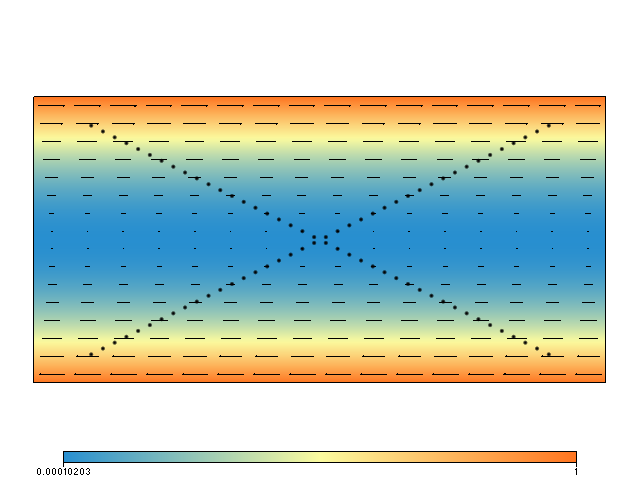

In [8]:
fig1 = glucifer.Figure()
fig1.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling=.1) )
fig1.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField, velocityField)) )
fig1.append( glucifer.objects.Points(line1.swarm, pointsize = 5))
fig1.append( glucifer.objects.Points(line2.swarm, pointsize = 5))

fig1.show()

In [9]:
proximity, fpts = line1.compute_marker_proximity(swarm.particleCoordinates.data)

proximityVariable.data[fpts] = proximity[fpts]


proximity, fpts = line2.compute_marker_proximity(swarm.particleCoordinates.data)

proximityVariable.data[fpts] = proximity[fpts]


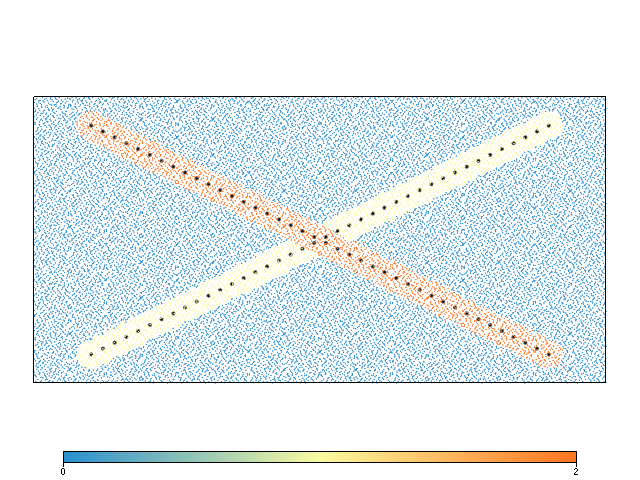

In [10]:
fig2 = glucifer.Figure()
fig2.append( glucifer.objects.Points(swarm, proximityVariable, pointsize = 2))
fig2.append( glucifer.objects.Points(line1.swarm, pointsize = 5))
fig2.append( glucifer.objects.Points(line2.swarm, pointsize = 5))


fig2.show()

In [11]:
#is this safe in parallel??

def proximity_director(self, swarm, proximity, normal, locFac=0.5, retainDistFac = 1.0   ):
    faultLoc = locFac*self.thickness
    #search twice the fault thickness
    sd, pts0 = self.compute_signed_distance(swarm.particleCoordinates.data, 
                                                distance=2.*retainDistFac*self.thickness)
    
    mask = np.logical_and(sd<(self.thickness - faultLoc),sd>-1.*faultLoc)[:,0]   
    proximity.data[mask ] = self.ID
    
    #director domain will be larger than proximity, but proximity will control rheology
    dv, nzv = self.compute_normals(swarm.particleCoordinates.data, retainDistFac*self.thickness)
    normal.data[mask, :] = dv[mask, :]
    
    #return sd, dv, mask

In [12]:
proximityVariable.data[:] = 0.

In [13]:
markerLine2D.proximity_director = proximity_director

In [14]:
dummy = markerLine2D.proximity_director(line1,swarm, proximityVariable, directorVariable, locFac=1. )

In [15]:
dummy = markerLine2D.proximity_director(line2,swarm, proximityVariable, directorVariable, locFac=1. )

In [16]:
#proximityVariable.data[mask ] = line.ID

In [17]:
#directorVariable.data[mask ] = dv[mask]

In [18]:
#dv[mask]


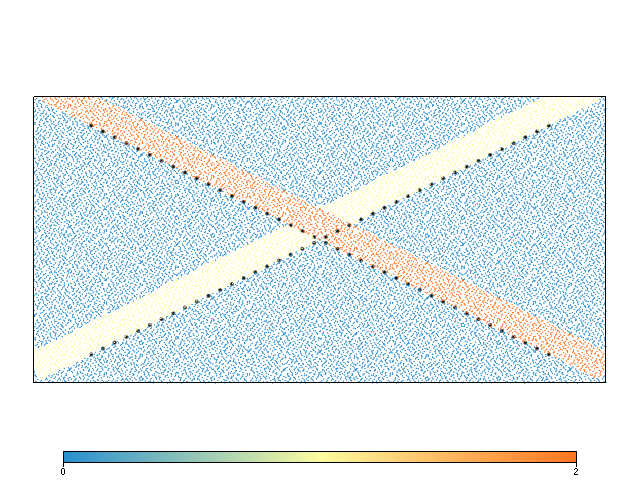

In [19]:
fig3 = glucifer.Figure()
fig3.append( glucifer.objects.Points(swarm, proximityVariable, pointsize = 2))
fig3.append( glucifer.objects.Points(line1.swarm, pointsize = 5))
fig3.append( glucifer.objects.Points(line2.swarm, pointsize = 5))
fig3.show()

## Strain rate components

In [21]:
#If there is just one marker line, we can use:
#edotn_SFn, edots_SFn = line1.local_strainrate_fns( velocityField, directorVariable, proximityVariable)

#However, if there are two markerlines it's better to put them in a collection and do this

line_coll = line_collection([line1, line2])

edotn_SFn, edots_SFn = line_coll.global_line_strainrate_fns( velocityField, directorVariable, proximityVariable)


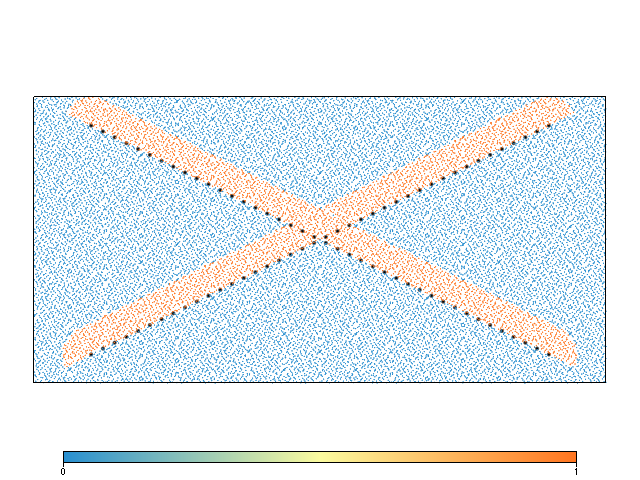

In [23]:
#

fig4 = glucifer.Figure()
fig4.append( glucifer.objects.Points(swarm, fn.math.sqrt(edots_SFn**2 + edotn_SFn**2), pointsize = 2))
fig4.append( glucifer.objects.Points(line1.swarm, pointsize = 5))
fig4.append( glucifer.objects.Points(line2.swarm, pointsize = 5))
fig4.show()